In [1]:
# Time Series Analysis in IoT for Traffic Management
# Group 12

# Model: Prophet Model

# Warning:
# This model is sequential.
# Attempting to juggle back and forth in the application may result is errors.
# Restarting the kernel can help solve the problem.

In [2]:
# Importing pandas to access and manipulate dataframes
import pandas as pd

# Importing numpy
import numpy as np

In [3]:
data = pd.read_csv("/kaggle/input/ml-iot/train_ML_IOT.csv")

In [4]:
# Previewing the original dataset
data

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041
...,...,...,...,...
48115,2017-06-30 19:00:00,4,11,20170630194
48116,2017-06-30 20:00:00,4,30,20170630204
48117,2017-06-30 21:00:00,4,16,20170630214
48118,2017-06-30 22:00:00,4,22,20170630224


In [5]:
# Checking if there are cells with missing values
data.isnull().sum()

DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64

In [6]:
# Viewing the statistics of the dataset
def display_data_desc(data, num, cat):
    display(data.describe(include = num))
    display(data.describe(include = cat))
    
data_types = ["float32", "float64", "int32", "int64", "object", "category", "datetime64[ns]"]

display_data_desc(data, data_types[:4], data_types[4:])

,Junction,Vehicles,ID
count,48120.000000,48120.000000,4.812000e+04
mean,2.180549,22.791334,2.016330e+10
std,0.966955,20.750063,5.944854e+06
min,1.000000,1.000000,2.015110e+10
25%,1.000000,9.000000,2.016042e+10
50%,2.000000,15.000000,2.016093e+10
75%,3.000000,29.000000,2.017023e+10
max,4.000000,180.000000,2.017063e+10


,DateTime
count,48120
unique,14592
top,2017-06-30 23:00:00
freq,4


In [7]:
# Converting the DateTime column to datetime format
data["DateTime"] = pd.to_datetime(data["DateTime"])

In [8]:
# Leaving out the ID column because it's not needed
data = data.drop(columns=["ID"])

In [9]:
# Formatting the dataset so that each Junction has its own column
data_pivot = data.pivot(index="DateTime", columns="Junction", values="Vehicles")

# Clipping out the rows where Junction 4 Vehicles are missing
data_pivot = data_pivot.tail(4344)

# Previewing the new formatted dataset
data_pivot

Junction,1,2,3,4
DateTime,,,,
2017-01-01 00:00:00,27.0,7.0,10.0,3.0
2017-01-01 01:00:00,23.0,9.0,6.0,1.0
2017-01-01 02:00:00,17.0,4.0,7.0,4.0
2017-01-01 03:00:00,16.0,4.0,7.0,4.0
2017-01-01 04:00:00,16.0,6.0,5.0,2.0
...,...,...,...,...
2017-06-30 19:00:00,105.0,34.0,33.0,11.0
2017-06-30 20:00:00,96.0,35.0,31.0,30.0
2017-06-30 21:00:00,90.0,31.0,28.0,16.0


In [10]:
# Importing the library for visualizing data
import matplotlib.pyplot as plot

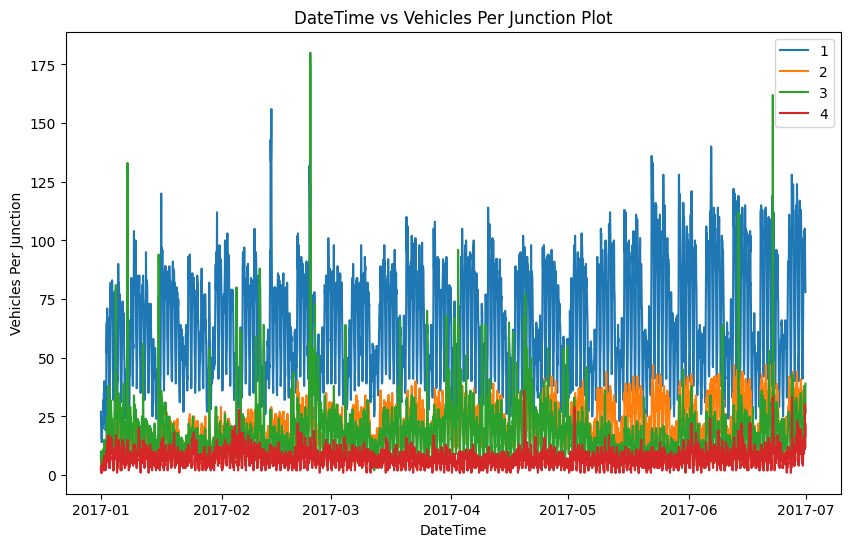

In [11]:
# Visualizing the formatted dataset to track the trend of the traffic in each junction
plot.figure(figsize=(10,6))
plot.plot(data_pivot)
plot.title("DateTime vs Vehicles Per Junction Plot")
plot.ylabel("Vehicles Per Junction")
plot.xlabel("DateTime")
plot.legend(data_pivot.columns)
plot.show()

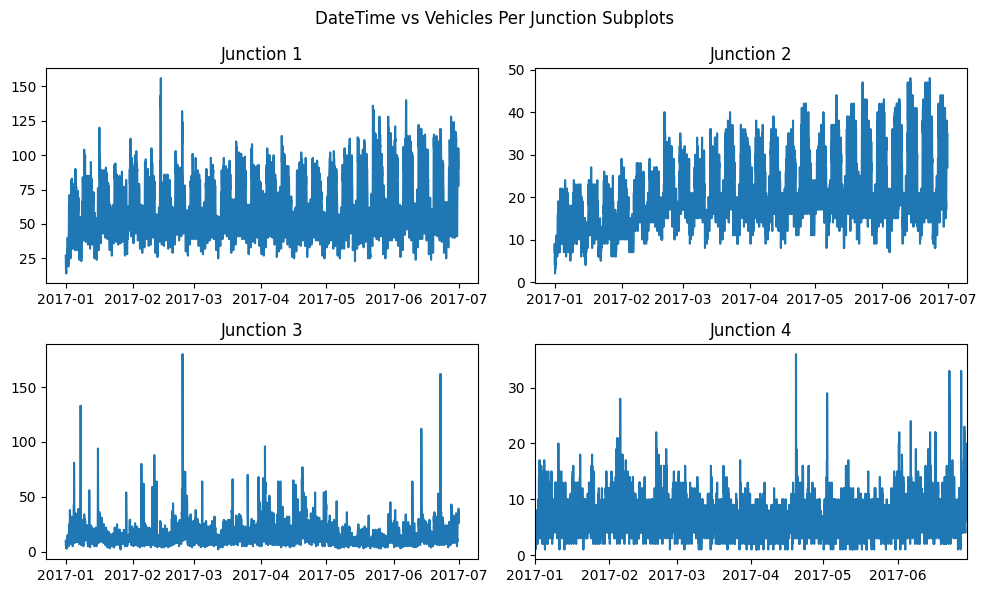

In [12]:
# Creating subplots so that each junction can be visualized individually
fig, axes = plot.subplots(2, 2, figsize=(10, 6))

# Setting the DateTime range to ensure that the trend is from the same period for each Juction
xrange = fig.gca()
xrange.set_xlim(pd.to_datetime(['2017-01-01', '2017-06-30']))

# Plotting the subplots
axes[0, 0].plot(data_pivot[1])
axes[0, 0].set_title("Junction 1")
axes[0, 1].plot(data_pivot[2])
axes[0, 1].set_title("Junction 2")
axes[1, 0].plot(data_pivot[3])
axes[1, 0].set_title("Junction 3")
axes[1, 1].plot(data_pivot[4])
axes[1, 1].set_title("Junction 4")
fig.suptitle("DateTime vs Vehicles Per Junction Subplots")
fig.tight_layout()

In [13]:
# Importing the Prophet model to initiate the prediction
from prophet import Prophet

In [14]:
# A function to predict traffic for one junction

def predict_traffic(junct, data_pivot, periods):
    
    # Filtering the dataset to target the Junction column
    data_junct = data_pivot[data_pivot["Junction"] == junct]
    
    #Renaming the DateTime and Vehicles columns to fit the Prophet model
    data_junct = data_junct.rename(columns={"DateTime": "ds", "Vehicles": "y"})
    
    # Creating the Prophet model
    model = Prophet()
    
    # Fitting the model to the dataset
    model.fit(data_junct)
    
    # Creating a future dataframe in hourly periods (4 months = 24 hours x 30 days x 4 months = 2880 hours)
    future = model.make_future_dataframe(periods=periods, include_history=False, freq="H")
    
    # Initiating the prediction
    forecast = model.predict(future)
    
    # Dropping unnecessary columns from the predicted dataset for viewing purposes
    forecast = forecast.drop(columns=["daily", "daily_lower", "daily_upper", "additive_terms", "additive_terms_upper", "additive_terms_lower", "weekly", "weekly_lower", "weekly_upper", "multiplicative_terms", "multiplicative_terms_upper", "multiplicative_terms_lower"])
    
    # Viewing the predicted dataset
    print(f"Junction {junct} Forecast DataFrame:")
    print(forecast)
    
    # Visualizing the prediction with graphs
    fig = model.plot(forecast)
    
    # Setting the range of dates to four months extension of the original dataset
    xrange = fig.gca()
    xrange.set_xlim(pd.to_datetime(['2017-07-01', '2017-10-30']))
    
    # Initiating the plots
    plot.title(f"Traffic Forecast For Junction {junct} In the Next 4 Months")
    plot.ylabel("Number of Vehicles")
    plot.xlabel("Time in Months")
    plot.show()
    
    return forecast

03:57:35 - cmdstanpy - INFO - Chain [1] start processing
03:57:41 - cmdstanpy - INFO - Chain [1] done processing


Junction 1 Forecast DataFrame:
                      ds      trend  yhat_lower  yhat_upper  trend_lower  \
0    2017-07-01 00:00:00  73.534911   59.372400   82.548987    73.534911   
1    2017-07-01 01:00:00  73.539141   54.455643   75.731616    73.539141   
2    2017-07-01 02:00:00  73.543370   47.411550   69.509940    73.543370   
3    2017-07-01 03:00:00  73.547599   41.224711   64.363858    73.547599   
4    2017-07-01 04:00:00  73.551828   38.445657   60.135909    73.551828   
...                  ...        ...         ...         ...          ...   
2875 2017-10-28 19:00:00  85.694150   63.903432  103.320148    69.122609   
2876 2017-10-28 20:00:00  85.698379   62.939572  102.660698    69.117088   
2877 2017-10-28 21:00:00  85.702609   61.695256   99.915592    69.111567   
2878 2017-10-28 22:00:00  85.706838   58.872512   99.249740    69.106046   
2879 2017-10-28 23:00:00  85.711067   55.183200   94.055470    69.100526   

      trend_upper       yhat  
0       73.534911  70.949

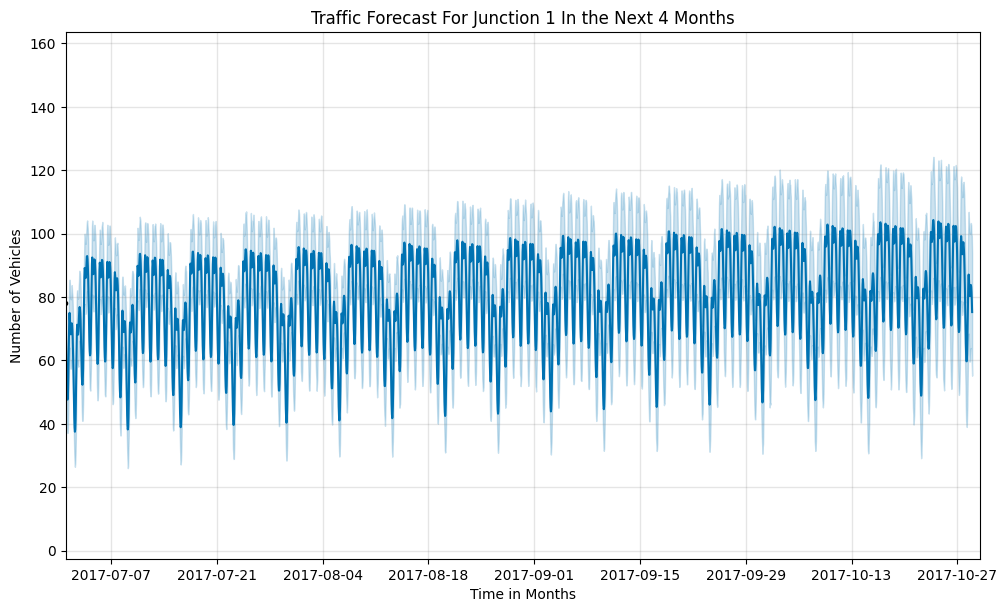

03:57:43 - cmdstanpy - INFO - Chain [1] start processing
03:57:51 - cmdstanpy - INFO - Chain [1] done processing


Junction 2 Forecast DataFrame:
                      ds      trend  yhat_lower  yhat_upper  trend_lower  \
0    2017-07-01 00:00:00  26.554176   22.569648   31.014646    26.554176   
1    2017-07-01 01:00:00  26.556139   21.363476   29.930320    26.556139   
2    2017-07-01 02:00:00  26.558102   19.857030   27.784658    26.558102   
3    2017-07-01 03:00:00  26.560065   17.707777   26.688608    26.560065   
4    2017-07-01 04:00:00  26.562028   16.467976   24.936209    26.562028   
...                  ...        ...         ...         ...          ...   
2875 2017-10-28 19:00:00  32.197256   23.691640   37.986054    26.438735   
2876 2017-10-28 20:00:00  32.199219   23.439548   37.613147    26.437614   
2877 2017-10-28 21:00:00  32.201182   23.339100   37.846507    26.436492   
2878 2017-10-28 22:00:00  32.203144   22.962702   36.997154    26.435370   
2879 2017-10-28 23:00:00  32.205107   21.845161   36.423532    26.434249   

      trend_upper       yhat  
0       26.554176  26.635

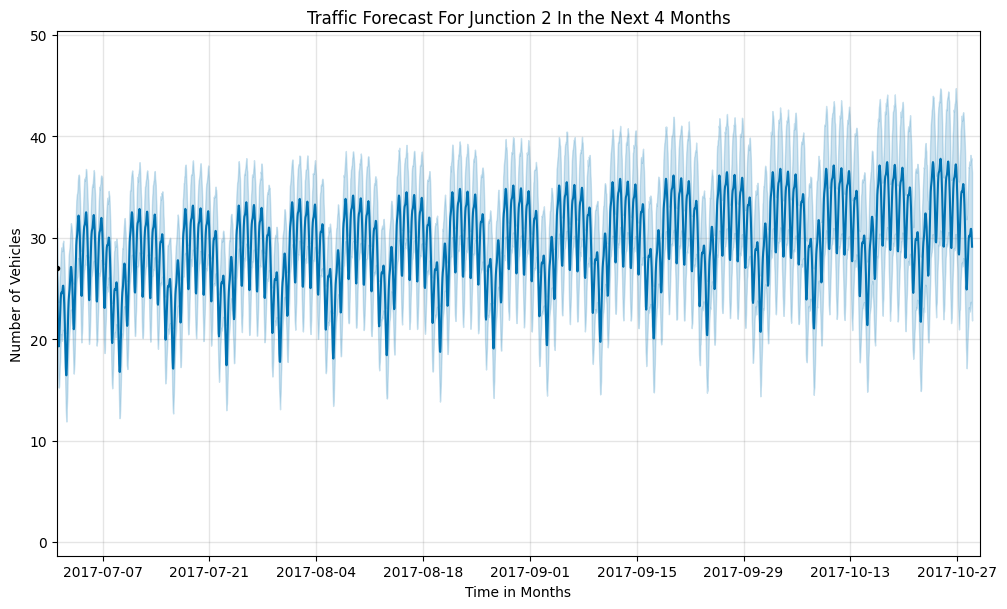

03:57:53 - cmdstanpy - INFO - Chain [1] start processing
03:57:59 - cmdstanpy - INFO - Chain [1] done processing


Junction 3 Forecast DataFrame:
                      ds      trend  yhat_lower  yhat_upper  trend_lower  \
0    2017-07-01 00:00:00  16.317725    5.274034   26.520192    16.317725   
1    2017-07-01 01:00:00  16.316785    3.116819   23.216016    16.316785   
2    2017-07-01 02:00:00  16.315844    0.573066   22.251349    16.315844   
3    2017-07-01 03:00:00  16.314904   -0.824430   20.525884    16.314904   
4    2017-07-01 04:00:00  16.313964   -2.028084   19.147940    16.313964   
...                  ...        ...         ...         ...          ...   
2875 2017-10-28 19:00:00  13.614285   -7.041519   46.231600   -11.870364   
2876 2017-10-28 20:00:00  13.613345   -7.257973   47.607151   -11.883848   
2877 2017-10-28 21:00:00  13.612405   -9.286844   46.426328   -11.897332   
2878 2017-10-28 22:00:00  13.611464  -10.074743   44.843358   -11.910816   
2879 2017-10-28 23:00:00  13.610524  -12.683017   41.565368   -11.924300   

      trend_upper       yhat  
0       16.317725  16.222

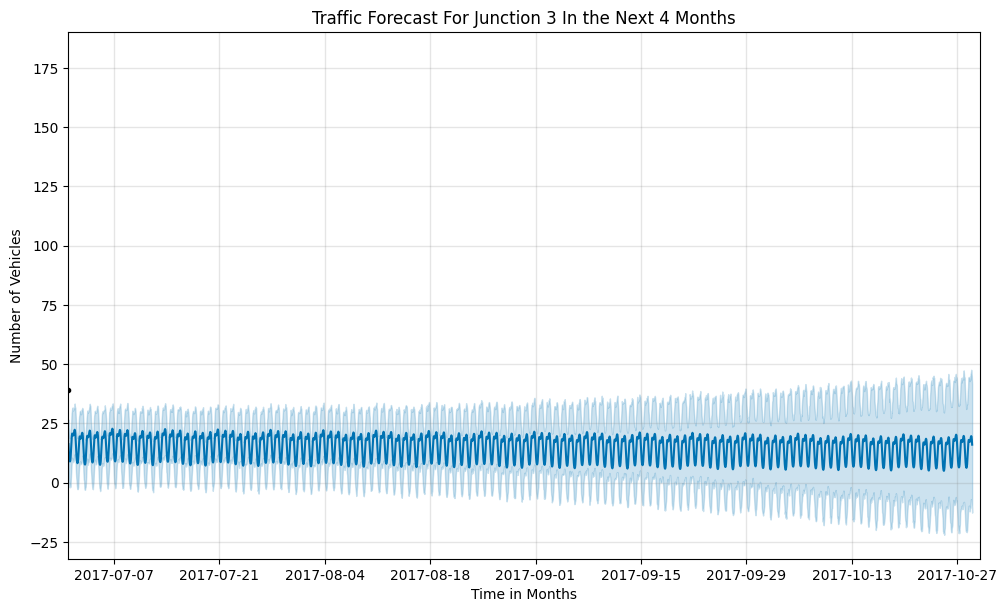

03:58:00 - cmdstanpy - INFO - Chain [1] start processing
03:58:01 - cmdstanpy - INFO - Chain [1] done processing


Junction 4 Forecast DataFrame:
                      ds      trend  yhat_lower  yhat_upper  trend_lower  \
0    2017-07-01 00:00:00   9.452868    5.888183   12.463072     9.452868   
1    2017-07-01 01:00:00   9.455902    4.338050   10.770801     9.455902   
2    2017-07-01 02:00:00   9.458937    3.327904   10.058879     9.458937   
3    2017-07-01 03:00:00   9.461971    2.826740    9.414309     9.461971   
4    2017-07-01 04:00:00   9.465006    2.555137    9.406194     9.465006   
...                  ...        ...         ...         ...          ...   
2875 2017-10-28 19:00:00  18.177097   13.874567   24.041510    14.203395   
2876 2017-10-28 20:00:00  18.180132   13.819169   23.794950    14.204850   
2877 2017-10-28 21:00:00  18.183166   13.300848   24.482574    14.206304   
2878 2017-10-28 22:00:00  18.186201   13.261347   24.272704    14.207759   
2879 2017-10-28 23:00:00  18.189235   12.735579   23.241610    14.209214   

      trend_upper       yhat  
0        9.452868   9.052

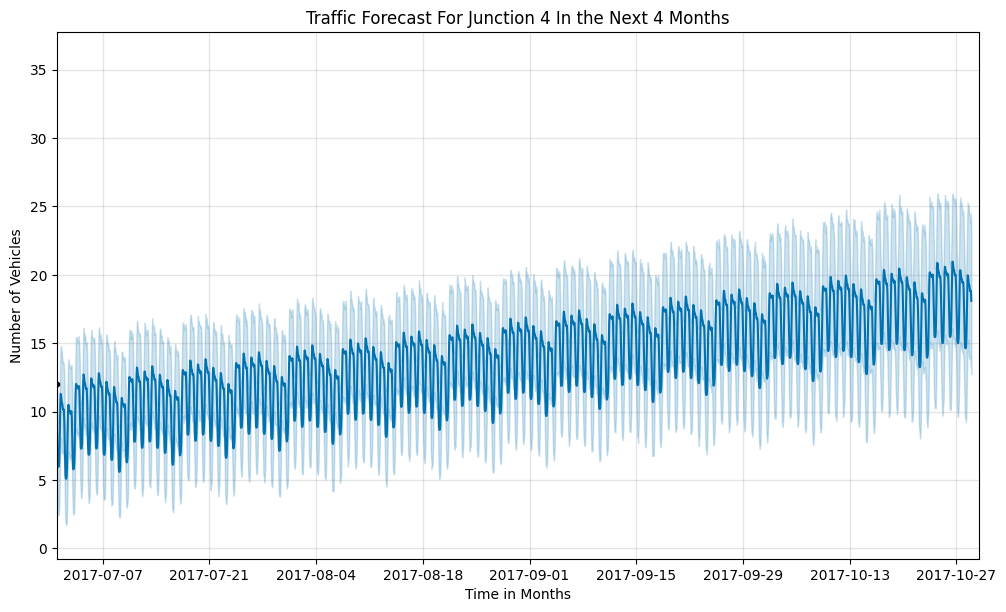

In [15]:
# Forecasting / Predicting the traffic for each junction in the next four months (2880 hours)
forecasts = {}
for junction in [1, 2, 3, 4]:
    forecasts[junction] = predict_traffic(junction, data, periods=2880)

In [16]:
# Extracting last 4 months of data to get a sample dataset that matches in size with the predicted dataset
data_pivot = data_pivot.tail(2880)

In [17]:
# Previewing the prediction to ensure that the number of rows match
for junct in [1, 2, 3, 4]:
    print(f"Junction {junct} Rows: {forecasts[junct].shape[0]}")

Junction 1 Rows: 2880
Junction 2 Rows: 2880
Junction 3 Rows: 2880
Junction 4 Rows: 2880


In [18]:
# Importing the MSE and the MAE to calculate the accuracy of the model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [19]:
# Calculating the Mean Square Error to evaluate the accuracy of the model
for junct in [1, 2, 3, 4]:
    print(f"Junction {junct} MSE: {r2_score(y_true=data_pivot[junct].values, y_pred=forecasts[junct]['yhat'].values)}")

Junction 1 MSE: 0.2671732547635979
Junction 2 MSE: -0.047424817506662276
Junction 3 MSE: 0.2988790023772796
Junction 4 MSE: -3.869482336884685


In [20]:
# Formatting the prediction for readability
for junct in [1, 2, 3, 4]:
    forecasts[junct] = forecasts[junct].rename(columns={"ds": "DateTime", "yhat": "Forecast", "yhat_upper": "Uncertainty Upper", "yhat_lower": "Uncertainty Lower"})
    forecasts[junct] = forecasts[junct].drop(columns=["trend", "trend_upper", "trend_lower"])
    cols = forecasts[junct].columns
    forecasts[junct][cols[1:]] = forecasts[junct][cols[1:]].astype(int)

In [21]:
# Previewing the 4 months forecast for any of the junctions
forecasts[1]

,DateTime,Uncertainty Lower,Uncertainty Upper,Forecast
0,2017-07-01 00:00:00,59,82,70
1,2017-07-01 01:00:00,54,75,64
2,2017-07-01 02:00:00,47,69,58
3,2017-07-01 03:00:00,41,64,53
4,2017-07-01 04:00:00,38,60,49
...,...,...,...,...
2875,2017-10-28 19:00:00,63,103,83
2876,2017-10-28 20:00:00,62,102,83
2877,2017-10-28 21:00:00,61,99,81
2878,2017-10-28 22:00:00,58,99,78


In [22]:
# Exporting the Output CSV file for each junction
for junct in [1, 2, 3, 4]:
    junct_df = forecasts[junct].to_csv(f"Junction {junct}.csv", index=True)
    print('\nCSV String:\n', junct_df)


CSV String:
 None

CSV String:
 None

CSV String:
 None

CSV String:
 None
